In [1]:
import pandas as pd
import os

import torch

from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

 
DATA_FOLDER_PTH=os.path.join(os.getcwd(), os.pardir, 'data')
 
TRAIN_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/train', 'train_splits')
TRAIN_TEXT_FILE_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/train', 'train_sent_emo.csv')
 
DEV_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/dev', 'dev_splits_complete')
DEV_TEXT_FILE_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/dev', 'dev_sent_emo.csv')
 
TEST_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/test', 'output_repeated_splits_test')
TEST_TEXT_FILE_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/test', 'test_sent_emo.csv')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
            print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 SUPER


In [3]:
%run text_dataset.ipynb

In [4]:
batchSize = 32    # as in paper
embedding_dim = 50


In [5]:
train_dataset = TextDataset(dataset_type = 'train', label_target = 'Emotion', embedding_dim = embedding_dim)
val_dataset = TextDataset(dataset_type = 'validation', label_target = 'Emotion', embedding_dim = embedding_dim)

In [6]:
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          num_workers=0,
                          batch_size=batchSize,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                          shuffle=True,
                          num_workers=0,
                          batch_size=batchSize,
                          pin_memory=True)

In [7]:
train_dataset[4][0].size()

torch.Size([100, 50])

In [8]:
#next(iter(train_loader))[0].size()

In [9]:
%run text_model_simpleLSTM.ipynb
%run text_model_FNN.ipynb
%run models_paper.ipynb

NVIDIA GeForce RTX 2070 SUPER


## Train simpleLSTM for emotion

In [10]:
# simpleLSTM or FNN or LSTMModel
model = simpleLSTM(embedding_dim = embedding_dim, output_dim = 7)

# droup_rate = 0.25
# D_m = embedding_dim #600
# D_e = 32 #100
# D_h = 32 #100

# model = LSTMModel(D_m, D_e, D_h,
#                   n_classes=7,
#                   dropout=droup_rate,
#                   attention=False)


model = model.to(device)
model

simpleLSTM(
  (lstm): LSTM(50, 32, batch_first=True)
  (classifier): Linear(in_features=32, out_features=7, bias=True)
  (relu): ReLU()
)

In [11]:
# labels = data['Emotion']
classes = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']

# class_weights = compute_class_weight('balanced', classes = classes, y = np.array(labels))
# class_weights = torch.tensor(class_weights, dtype=torch.float)

# class_weights = class_weights.to(device)
# print(class_weights)

# Checking output before training

In [12]:
val_loader = DataLoader(val_dataset,
                          shuffle=False,
                          num_workers=0,
                          batch_size=len(val_dataset),
                          pin_memory=True)

In [13]:
with torch.no_grad():
    
    model.eval()
    
    X, y = next(iter(val_loader))
    #print(X, y)
    X = X.to(device)
    
    out = model(X)
    print(out)
    predictions = F.softmax(out, dim=1).cpu()
    #print(predictions)
    
    predictions = torch.argmax(predictions, dim = 1).numpy().astype(dtype=np.float)
    y = y.numpy().astype(dtype=np.float)
    #print(predictions)
    #print(y)
    print(metrics.classification_report(y, predictions, target_names=classes))

tensor([[ 0.1243,  0.1143,  0.1559,  ..., -0.0062,  0.0250,  0.1636],
        [ 0.1243,  0.1143,  0.1559,  ..., -0.0062,  0.0250,  0.1636],
        [ 0.1243,  0.1143,  0.1559,  ..., -0.0062,  0.0250,  0.1636],
        ...,
        [ 0.1243,  0.1143,  0.1559,  ..., -0.0062,  0.0250,  0.1636],
        [ 0.1243,  0.1143,  0.1559,  ..., -0.0062,  0.0250,  0.1636],
        [ 0.1243,  0.1143,  0.1559,  ..., -0.0062,  0.0250,  0.1636]],
       device='cuda:0')
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       470
    surprise       0.00      0.00      0.00       150
        fear       0.00      0.00      0.00        40
     sadness       0.00      0.00      0.00       111
         joy       0.00      0.00      0.00       163
     disgust       0.00      0.00      0.00        22
       anger       0.14      1.00      0.24       153

    accuracy                           0.14      1109
   macro avg       0.02      0.14      0.03      1109


D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
pd.DataFrame(metrics.confusion_matrix(y, predictions), index = classes, columns = classes)

,neutral,surprise,fear,sadness,joy,disgust,anger
neutral,0,0,0,0,0,0,470
surprise,0,0,0,0,0,0,150
fear,0,0,0,0,0,0,40
sadness,0,0,0,0,0,0,111
joy,0,0,0,0,0,0,163
disgust,0,0,0,0,0,0,22
anger,0,0,0,0,0,0,153


In [15]:
def trainLoop(model, train_loader, val_loader, shouldSave=False):
    
    model.train()
    
    EPOCHS = 10
    lr = 0.0001                                        # as in paper
    weight_decay = 0.00001                             # as in paper
    
    #criterion = MaskedNLLLoss()                        # as in paper
    optimizer = optim.Adam(model.parameters(),         # as in paper
                           lr=lr,
                           weight_decay=weight_decay)
    
    
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr)
#     criterion = nn.CrossEntropyLoss(weight=class_weights)
#     optimizer = optim.Adadelta(model.parameters())
    

    i = 0
    counterTrain = []
    lossHistoryTrain = []

    j = 0
    counterVal = []
    lossHistoryVal = []
    epochsSinceLastImprovement = 0
    bestLoss = None
    bestModel = model.state_dict()

    for epoch in tqdm(range(0, EPOCHS)):
        
        model.train()
        
        trainLoss = 0

        for data in train_loader:
            
            X, y = data
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            #print(X.shape)
            out = model(X)
            
            #print(out[0])
            #print(y)
            loss = criterion(out, y)
            loss.backward()
            
            trainLoss += loss.item()
            
            optimizer.step()

        trainLoss = trainLoss / len(train_loader)
            
        counterTrain.append(epoch)
        lossHistoryTrain.append(trainLoss)
        
        model.eval()
        with torch.no_grad():

            validationLoss = 0

            for data in val_loader:

                X, y = data
                X = X.to(device)
                y = y.to(device)
                
                out = model(X)

                loss = criterion(out, y)

                validationLoss += loss

            
            validationLoss = validationLoss / len(val_loader)
            
            counterVal.append(epoch)
            lossHistoryVal.append(validationLoss)


    return model, counterTrain, lossHistoryTrain, counterVal, lossHistoryVal

In [16]:
model, counterTrain, lossHistoryTrain, counterVal, lossHistoryVal = trainLoop(model, train_loader, val_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.00s/it]


In [17]:
def plotLoss(counter_train, loss_history_train, counter_test, loss_history_test, shouldSave=False, shouldDisplay=True):
    
    plt.plot(counter_train, loss_history_train, label="Train")

    plt.plot(counter_test, loss_history_test, label="Val")
    
    plt.legend(['Train', 'Val'])
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

#     fig, ax = plt.subplots(2, figsize=(12.83, 9.19))
#     #fig.suptitle(f'BestModelAtEpoch: {self.earlyStoppedAtEpoch} lr: {self.lr}, weightDecay: {self.weightDecay}, momentum: {self.momentum}, batchSize:{self.batchSize}, optim: {self.optim}, lastLayerActivation:{self.lastLayerActivation}')

#     ax[0].plot(counter_train, loss_history_train, label="Train")
#     ax[0].grid(True)

#     ax[1].plot(counter_test, loss_history_test, label="Test")
#     ax[1].grid(True)

#     if shouldSave:
#         today = datetime.now()
#         path = "./Figures/" + today.strftime('%d_%m_%Y_%H_%M')
#         fig.tight_layout()
#         fig.subplots_adjust(top=.95)
#         plt.savefig(path, dpi=300)

    if shouldDisplay:
        plt.show()

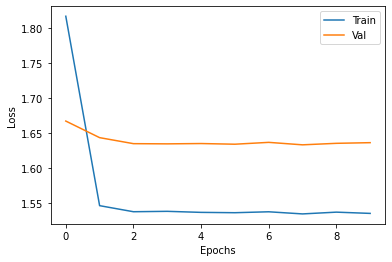

In [18]:
plotLoss(counterTrain, lossHistoryTrain, counterVal, lossHistoryVal)

# Evaluation

In [19]:
val_loader = DataLoader(val_dataset,
                          shuffle=False,
                          num_workers=0,
                          batch_size=len(val_dataset),
                          pin_memory=True)

In [20]:
with torch.no_grad():
    
    model.eval()
    
    X, y = next(iter(val_loader))
    print(X.shape)
    print(y)
    X = X.to(device)
    
    out = model(X)
    print(out)
    predictions = F.softmax(out, dim=1).cpu()
    #print(predictions)
    
    predictions = torch.argmax(predictions, dim = 1).numpy().astype(dtype=np.float)
    y = y.numpy().astype(dtype=np.float)
    print(predictions)
    print(y)
    print(metrics.classification_report(y, predictions, target_names=classes))

torch.Size([1109, 100, 50])
tensor([3, 1, 0,  ..., 3, 3, 3])
tensor([[ 1.4483,  0.0733, -1.4526,  ...,  0.4189, -1.4259, -0.0364],
        [ 1.4483,  0.0733, -1.4526,  ...,  0.4189, -1.4259, -0.0364],
        [ 1.4483,  0.0733, -1.4526,  ...,  0.4189, -1.4259, -0.0364],
        ...,
        [ 1.4483,  0.0733, -1.4526,  ...,  0.4189, -1.4259, -0.0364],
        [ 1.4483,  0.0733, -1.4526,  ...,  0.4189, -1.4259, -0.0364],
        [ 1.4483,  0.0733, -1.4526,  ...,  0.4189, -1.4259, -0.0364]],
       device='cuda:0')
[0. 0. 0. ... 0. 0. 0.]
[3. 1. 0. ... 3. 3. 3.]
              precision    recall  f1-score   support

     neutral       0.42      1.00      0.60       470
    surprise       0.00      0.00      0.00       150
        fear       0.00      0.00      0.00        40
     sadness       0.00      0.00      0.00       111
         joy       0.00      0.00      0.00       163
     disgust       0.00      0.00      0.00        22
       anger       0.00      0.00      0.00       153


D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
pd.DataFrame(metrics.confusion_matrix(y, predictions), index = classes, columns = classes)

,neutral,surprise,fear,sadness,joy,disgust,anger
neutral,470,0,0,0,0,0,0
surprise,150,0,0,0,0,0,0
fear,40,0,0,0,0,0,0
sadness,111,0,0,0,0,0,0
joy,163,0,0,0,0,0,0
disgust,22,0,0,0,0,0,0
anger,153,0,0,0,0,0,0
